In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("processed_data18.csv") 
df.head(n=5)  # visualize the data.

,Unnamed: 0,time,y,x1,x2,x3,x4,x5,x6,x7,...,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60,trend_x61
0,0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Columns: 612 entries, Unnamed: 0 to trend_x61
dtypes: float64(600), int64(11), object(1)
memory usage: 85.9+ MB


In [4]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [5]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Unnamed: 0,time,y,x1,x2
256,256,5/1/99 8:32,0,1.016235,-4.058394
257,257,5/1/99 8:34,0,1.005602,-3.876199
258,258,5/1/99 8:36,0,0.933933,-3.868467
259,259,5/1/99 8:38,1,0.892311,-13.332664
260,260,5/1/99 10:50,0,0.020062,-3.987897


After shifting


,y,Unnamed: 0,time,x1,x2
255,0.0,255,5/1/99 8:30,0.997107,-3.865720
256,0.0,256,5/1/99 8:32,1.016235,-4.058394
257,1.0,257,5/1/99 8:34,1.005602,-3.876199
258,1.0,258,5/1/99 8:36,0.933933,-3.868467
260,0.0,260,5/1/99 10:50,0.020062,-3.987897


In [6]:
# Remove time column
df = df.drop(['time'], axis=1)

In [7]:
X = df.drop(['y'], axis=1)
y = df['y']

In [8]:
X
X=X.fillna(0)
X

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60,trend_x61
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,18393,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18394,18394,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18395,18395,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18396,18396,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X = X.drop(['Unnamed: 0'], axis=1)
X

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60,trend_x61
0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18394,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18395,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18396,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X = X.drop(['drift_x61'], axis=1)
X

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60,trend_x61
0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18394,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18395,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18396,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,-0.038189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((14619, 608), (3655, 608))

In [14]:
# Feature scaling

In [15]:
cols = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


In [17]:
# define model
model = XGBClassifier()


In [ ]:
#SMOTE-Tomek
#Over-sampling using SMOTE and cleaning using Tomek links.
#Combine over- and under-sampling using SMOTE and Tomek links.

In [25]:
# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_059ba16b00a14e0b92e02a34fd5dd379/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

Mean ROC AUC: 0.97814


In [27]:
model = XGBClassifier()

clf_0 = pipeline.fit(X_train, y_train)


In [28]:
pred_y_0 = clf_0.predict(X_test)

print(accuracy_score(pred_y_0, y_test))

0.9909712722298222


In [29]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_0, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_0)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      3608
     class 1       0.75      0.45      0.56        47

    accuracy                           0.99      3655
   macro avg       0.87      0.72      0.78      3655
weighted avg       0.99      0.99      0.99      3655



array([[3601,    7],
       [  26,   21]])

In [32]:
pipeline

Pipeline(steps=[('r',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [33]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [51]:
xgb_modelq = pipeline.steps[-1][1]

<AxesSubplot:>

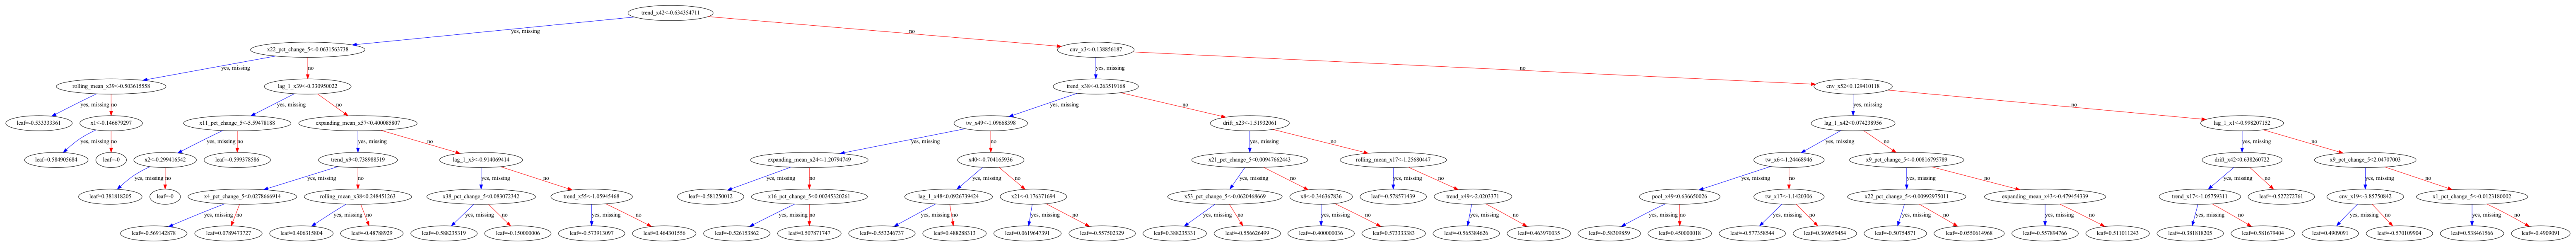

In [52]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(xgb_modelq)
#yes, missing here means this tree has handled missing values

# Weighted XGBoost for Class Imbalance


In [53]:
# define model
#scale_pos_weight=total_negative_examples / total_positive_examples
#total number of examples in the majority class / total number of examples in the minority class.
#18274/124=147.37
model = XGBClassifier(scale_pos_weight=147)

# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_e678fa8a949f4ca4ba76750ca29bc8da/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

Mean ROC AUC: 0.97088


In [54]:
clf_1 = pipeline.fit(X_train, y_train)
pred_y_1 = clf_1.predict(X_test)

print(accuracy_score(pred_y_1, y_test))

0.987140902872777


In [55]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_1, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_1)

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      3608
     class 1       0.50      0.57      0.53        47

    accuracy                           0.99      3655
   macro avg       0.75      0.78      0.76      3655
weighted avg       0.99      0.99      0.99      3655



array([[3581,   27],
       [  20,   27]])

<AxesSubplot:>

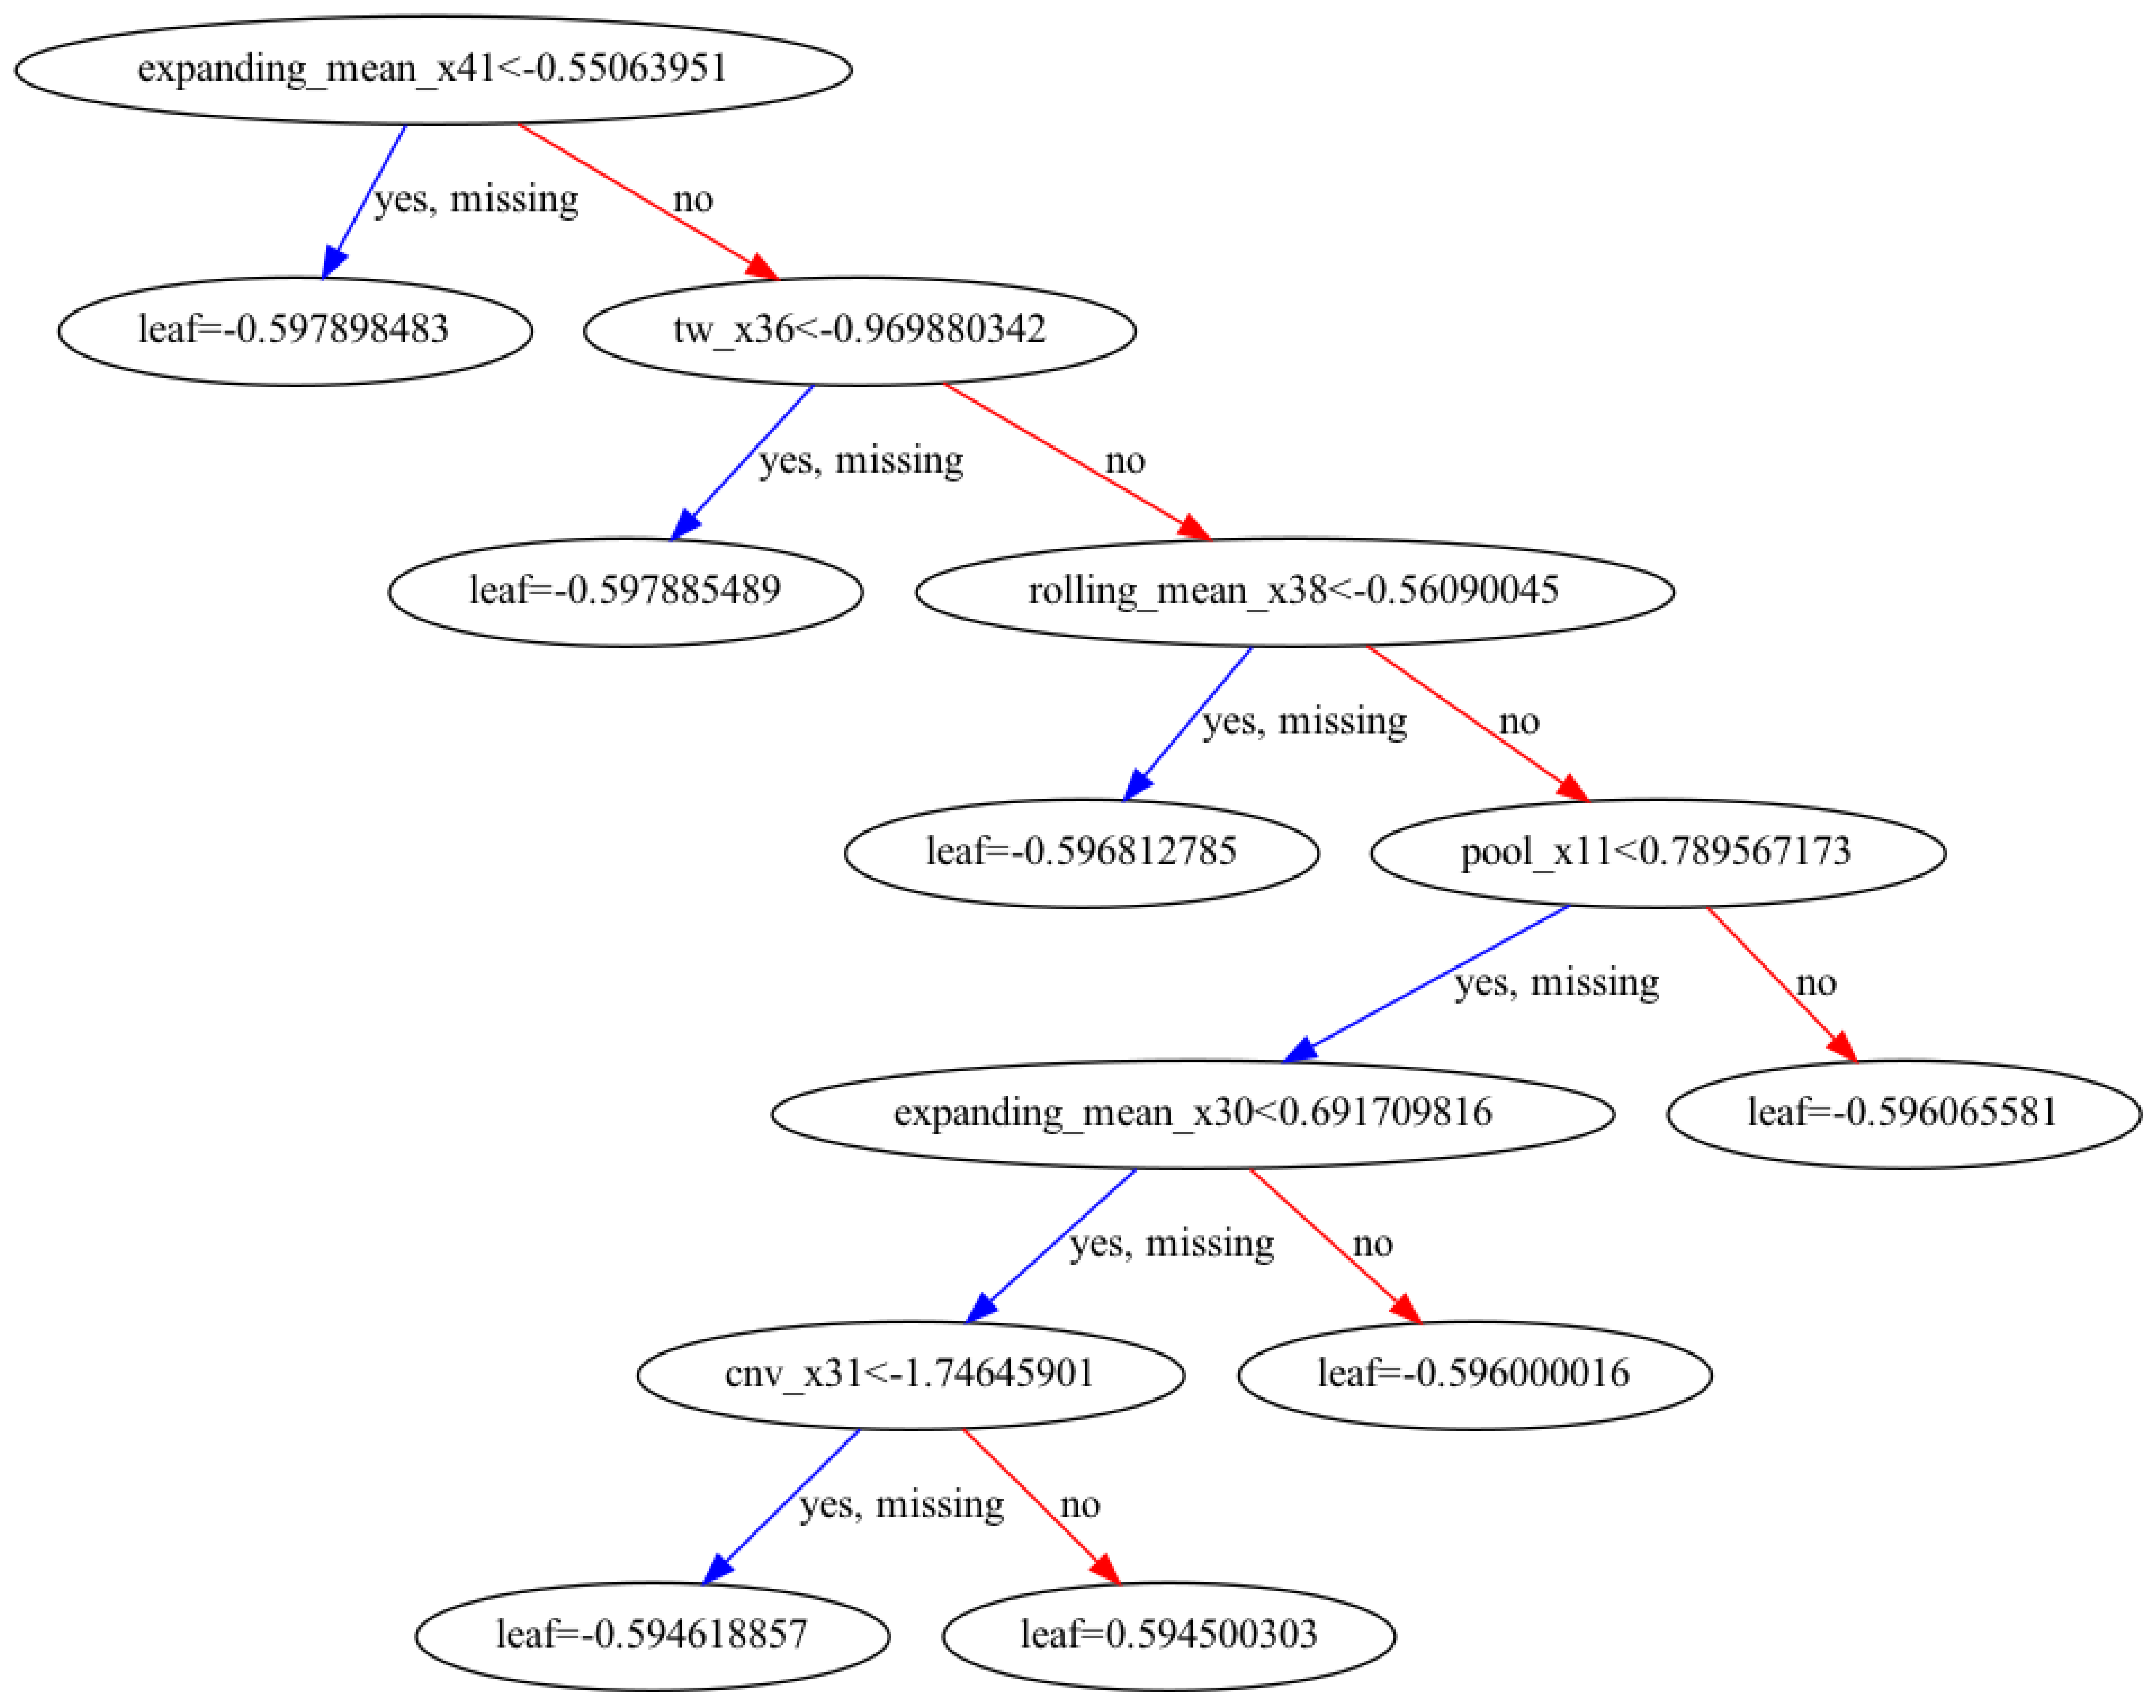

In [56]:
xgb_model = pipeline.steps[-1][1] # the XGBoost model is the last step in the pipeline
 

%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(xgb_model)
#yes, missing here means this tree has handled missing values

# Tune with GridSearch CV

In [57]:
# define grid
weights = [1, 10, 25, 50, 75, 99, 100,700,800,1000,2000]
param_grid = dict(scale_pos_weight=weights)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [ ]:
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [20]:
# define model
model = XGBClassifier(scale_pos_weight=10)

# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.97611


In [21]:
clf_2 = pipeline.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))

0.9898768809849521


In [22]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      3608
     class 1       0.64      0.49      0.55        47

    accuracy                           0.99      3655
   macro avg       0.82      0.74      0.77      3655
weighted avg       0.99      0.99      0.99      3655



array([[3595,   13],
       [  24,   23]])

In [27]:
import shap

# Initialize TreeExplainer
explainer = shap.TreeExplainer(model)

In [28]:
explainer

In [ ]:
# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model, X)
shap_values_xgb = explainer_xgb(X)

sample_ind=20
# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "x3", model.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)


 51%|==========          | 9342/18274 [00:25<00:23]       

<AxesSubplot:>

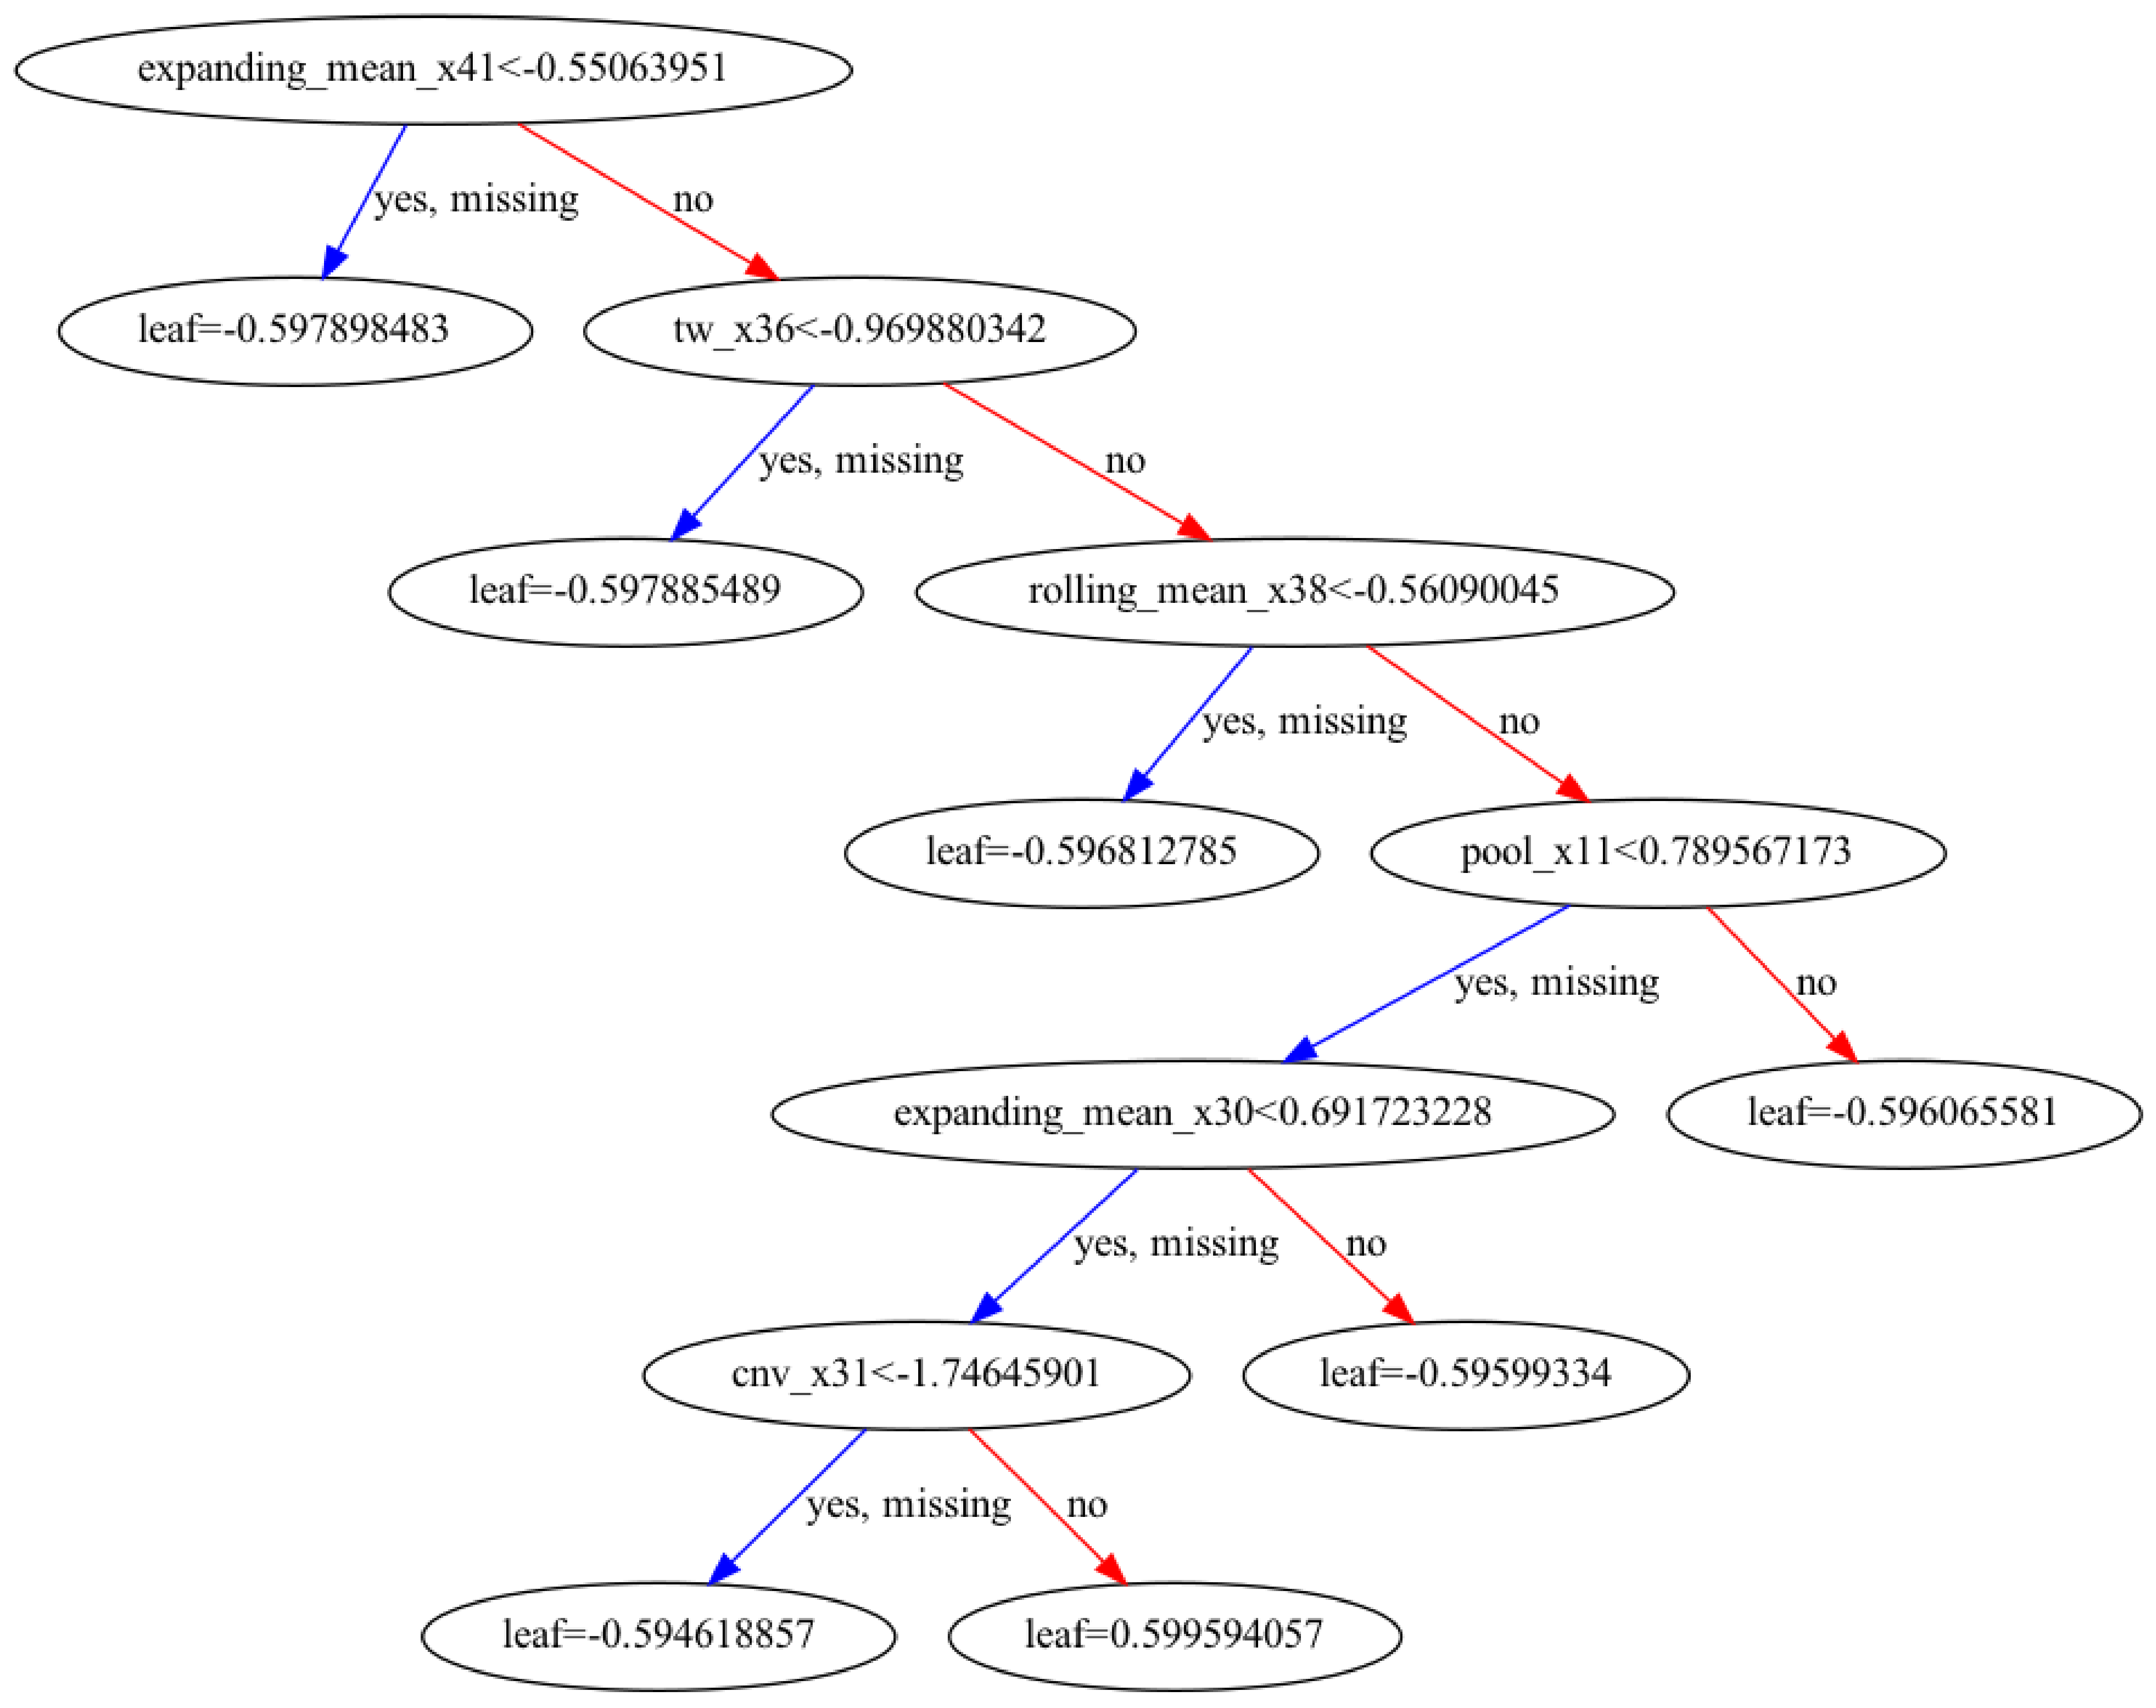

In [61]:
xgb_model = pipeline.steps[-1][1] # the XGBoost model is the last step in the pipeline

%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(xgb_model)
#yes, missing here means this tree has handled missing values

In [62]:
# define model
model = XGBClassifier()

# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='all'))
# Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 96  96  96 ...  96  96  96]
 [  0   0   0 ...   0   0   0]
 [ 95  95  95 ...  95  95  95]
 ...
 [ 96  95  95 ... 118 118 118]
 [ 96  96  96 ...  96  96  96]
 [  0   0   0 ...   0   0   0]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_ba6723284a7646ef91a2b0ac72681b4d/2643-140489649999680-76994ef12ae24c01881e5dfba1e8cf00.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.475720

Mean ROC AUC: 0.97405


In [63]:
clf_2 = pipeline.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))

0.9906976744186047


In [64]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      3608
     class 1       0.72      0.45      0.55        47

    accuracy                           0.99      3655
   macro avg       0.86      0.72      0.77      3655
weighted avg       0.99      0.99      0.99      3655



array([[3600,    8],
       [  26,   21]])

In [ ]:
#SMOTE-ENN
#Over-sampling using SMOTE and cleaning using ENN.
#Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.

In [85]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
# define model
model = XGBClassifier()

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_67dcd9e928854ce699b76a9a0d524ee0/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

Mean ROC AUC: 0.97445


In [86]:
clf_2 = pipeline.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))

0.9857729138166894


In [87]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      3608
     class 1       0.45      0.49      0.47        47

    accuracy                           0.99      3655
   macro avg       0.72      0.74      0.73      3655
weighted avg       0.99      0.99      0.99      3655



array([[3580,   28],
       [  24,   23]])

In [69]:
#ADASYN

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)

In [71]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1.0: 18063, 0.0: 18027})


In [ ]:
#Oversample using Adaptive Synthetic (ADASYN) algorithm.
#This method is similar to SMOTE but it generates different number of samples depending 
#on an estimate of the local distribution of the class to be oversampled.

In [73]:
model = XGBClassifier()

#Define ADASYN
resample=ADASYN(random_state=42)
#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])
#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_bd5272dee5a74852845bfdcbc75e2059/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_bd5272dee5a74852845bfdcbc75e2059/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_bd5272dee5a74852845bfdcbc75e2059/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_bd5272dee5a74852845bfdcbc75e2059/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

/Users/chathurangishyalika/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 0.37666549  0.47572049  0.36384849 ... -0.8265475  -0.8228425
  -0.8409805 ]
 [-4.5964348  -4.5425018  -4.6813938  ...  0.45012618  0.41938318
   0.58271018]
 [-4.0957558  -4.0183588  -4.3531468  ...  0.3345822   0.3872632
   0.5934162 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] loaded from the file /var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/joblib_memmapping_folder_2643_dbf5f8ee79324a0e89ce263295f670b3_bd5272dee5a74852845bfdcbc75e2059/2643-140489649999680-e7548716f4d54a7eacda3d1dc0b87cb2.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pic

Mean ROC AUC: 0.97563


In [74]:
clf_2 = pipeline.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))

0.9906976744186047


In [80]:
clf_2 = pipeline.fit(X_train, y_train)
pred_y_train = clf_2.predict(X_train)

print(accuracy_score(pred_y_train, y_train))

1.0


In [81]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      3608
     class 1       0.76      0.40      0.53        47

    accuracy                           0.99      3655
   macro avg       0.88      0.70      0.76      3655
weighted avg       0.99      0.99      0.99      3655



array([[3602,    6],
       [  28,   19]])